<a href="https://colab.research.google.com/github/2320030014/OIBSIP/blob/main/Project_4_Proposal_Level_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn xgboost category_encoders openpyxl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
import category_encoders as ce
import joblib
sns.set(style='whitegrid')


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving apps.csv to apps.csv


In [ ]:
import pandas as pd

df = pd.read_csv('apps.csv')   # must match the exact filename shown above
print("Shape:", df.shape)
df.head()


Shape: (9659, 14)


,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [ ]:
print(df.columns.tolist())
df.info()
df.isnull().sum().sort_values(ascending=False).head(20)


['Unnamed: 0', 'App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      9659 non-null   int64  
 1   App             9659 non-null   object 
 2   Category        9659 non-null   object 
 3   Rating          8196 non-null   float64
 4   Reviews         9659 non-null   int64  
 5   Size            8432 non-null   float64
 6   Installs        9659 non-null   object 
 7   Type            9659 non-null   object 
 8   Price           9659 non-null   object 
 9   Content Rating  9659 non-null   object 
 10  Genres          9659 non-null   object 
 11  Last Updated    9659 non-null   object 
 12  Current Ver     9651 non-null   object 
 13  Android Ver     9657 non-null   object 
dtypes:

,0
Rating,1463
Size,1227
Current Ver,8
Android Ver,2
App,0
Unnamed: 0,0
Reviews,0
Category,0
Installs,0
Type,0


In [ ]:
# Copy original
data = df.copy()

# 1) Strip whitespace from column names
data.columns = data.columns.str.strip().str.replace(' ', '_').str.replace('-', '_').str.lower()

# Example column fixes (adapt to your columns)
# Convert price like '$2.99' -> float
if 'price' in data.columns:
    data['price'] = data['price'].astype(str).str.replace(r'[\$\,]', '', regex=True).replace('Free','0').replace('', np.nan)
    data['price'] = pd.to_numeric(data['price'], errors='coerce')

# Convert installs like '1,000,000+' -> int
if 'installs' in data.columns:
    data['installs'] = data['installs'].astype(str).str.replace(r'[+,]', '', regex=True)
    data['installs'] = pd.to_numeric(data['installs'], errors='coerce')

# Convert size like '19M' or 'Varies with device'
if 'size' in data.columns:
    def parse_size(s):
        if pd.isna(s): return np.nan
        s = s.strip()
        if s.lower() == 'varies with device': return np.nan
        if s.endswith('k') or s.endswith('K'):
            return float(s[:-1]) / 1024  # convert KB to MB
        if s.endswith('m') or s.endswith('M'):
            return float(s[:-1])
        try:
            return float(s)
        except:
            return np.nan
    data['size_mb'] = data['size'].astype(str).apply(parse_size)

# Convert reviews to numeric
if 'reviews' in data.columns:
    data['reviews'] = pd.to_numeric(data['reviews'], errors='coerce')

# Convert rating to numeric
if 'rating' in data.columns:
    data['rating'] = pd.to_numeric(data['rating'], errors='coerce')

# Dates: last_updated
if 'last_updated' in data.columns:
    data['last_updated'] = pd.to_datetime(data['last_updated'], errors='coerce')

data.head()


,unnamed:_0,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver,size_mb
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up,19.0
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,14.0
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up,8.7
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,2018-06-08,Varies with device,4.2 and up,25.0
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4 and up,2.8


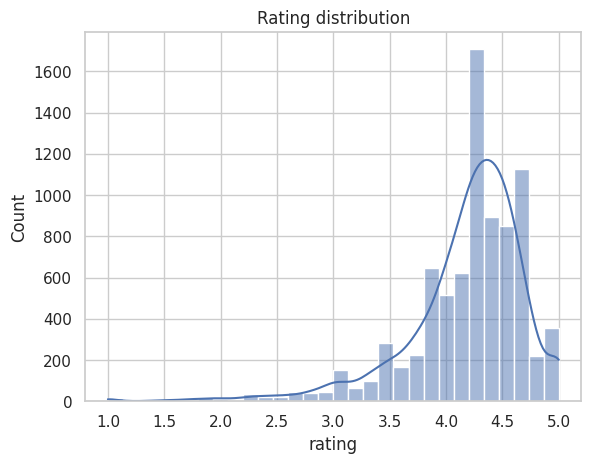

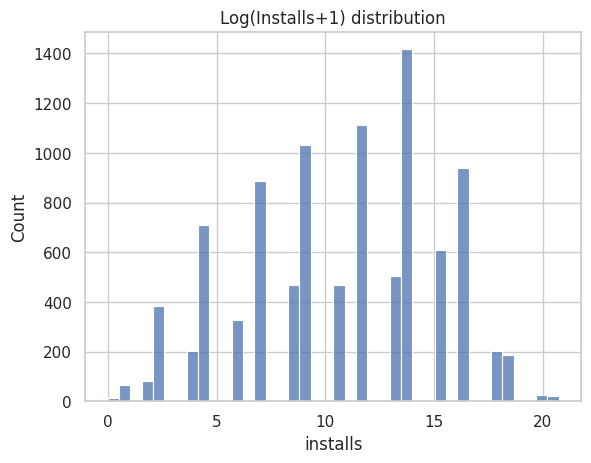

In [ ]:
# Rating distribution
sns.histplot(data['rating'].dropna(), bins=30, kde=True)
plt.title('Rating distribution')
plt.show()

# Installs distribution (log scale)
sns.histplot(np.log1p(data['installs'].dropna()), bins=40)
plt.title('Log(Installs+1) distribution')
plt.show()


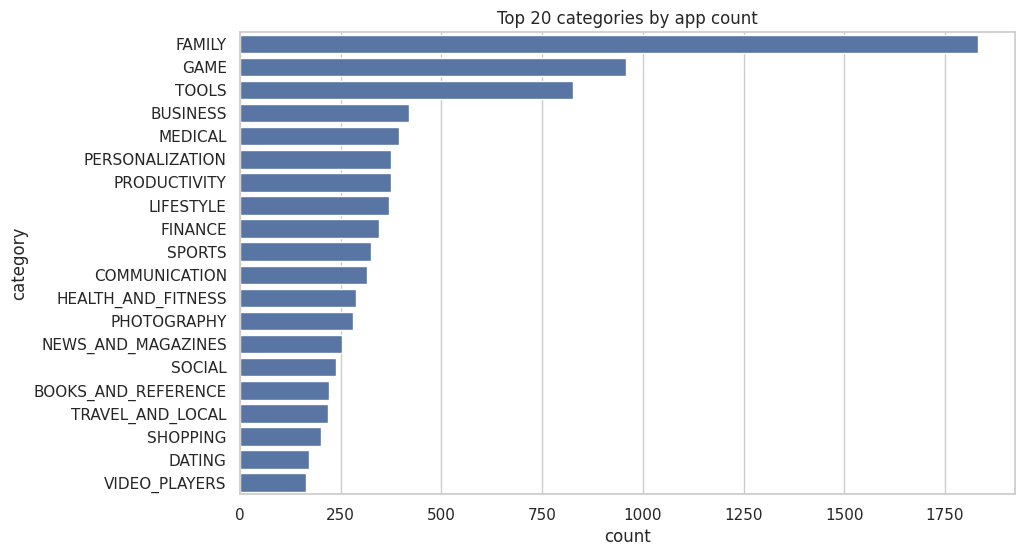

In [ ]:
if 'category' in data.columns:
    plt.figure(figsize=(10,6))
    sns.countplot(y='category', data=data, order=data['category'].value_counts().index[:20])
    plt.title('Top 20 categories by app count')
    plt.show()


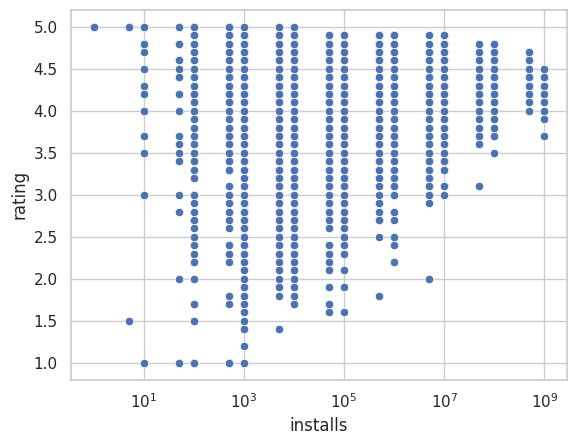

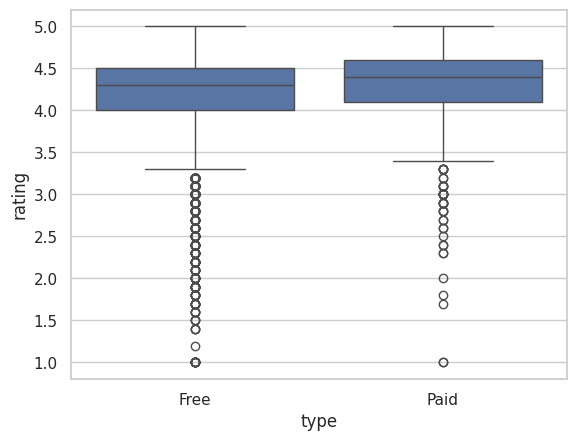

In [ ]:
# Rating vs Installs
sns.scatterplot(x='installs', y='rating', data=data)
plt.xscale('log')
plt.show()

# Price vs Rating (if paid apps exist)
sns.boxplot(x='type', y='rating', data=data)
plt.show()


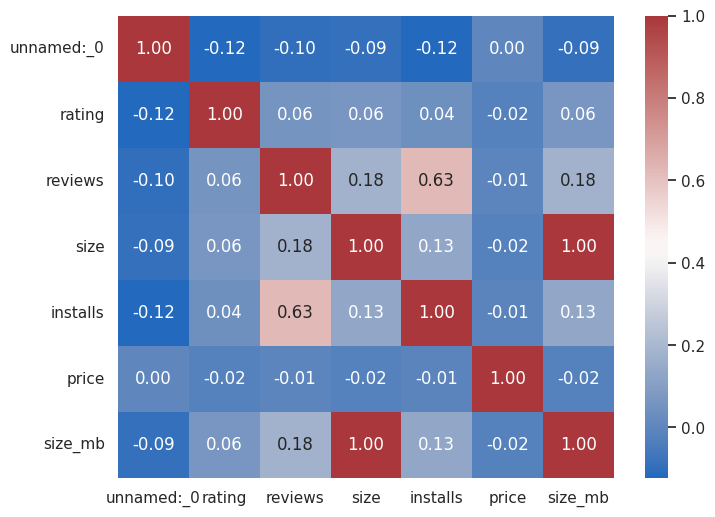

In [ ]:
num_cols = data.select_dtypes(include='number').columns
plt.figure(figsize=(8,6))
sns.heatmap(data[num_cols].corr(), annot=True, fmt='.2f', cmap='vlag')
plt.show()


In [ ]:
# 1) Feature: is_paid
if 'type' in data.columns:
    data['is_paid'] = data['type'].fillna('Free').apply(lambda x: 1 if x.lower().strip()=='paid' else 0)

# 2) Reviews per install
data['reviews_per_install'] = data.apply(lambda r: r['reviews']/r['installs'] if pd.notnull(r.get('reviews')) and pd.notnull(r.get('installs')) and r['installs']>0 else 0, axis=1)

# 3) Days since last update
if 'last_updated' in data.columns:
    ref_date = pd.to_datetime('today')
    data['days_since_update'] = (ref_date - data['last_updated']).dt.days

# 4) Genres split: keep primary genre
if 'genres' in data.columns:
    data['primary_genre'] = data['genres'].astype(str).str.split(';').str[0]

# 5) Price bucket
if 'price' in data.columns:
    data['price_bucket'] = pd.cut(data['price'].fillna(0), bins=[-1,0,0.99,4.99,19.99,1000], labels=['free','cheap','mid','expensive','very_expensive'])


In [ ]:
# Select features (adjust if some columns absent)
features = ['category', 'primary_genre', 'size_mb', 'is_paid', 'price', 'reviews', 'installs', 'reviews_per_install', 'days_since_update']
target_reg = 'rating'
# Drop rows where target missing for regression
df_reg = data[features + [target_reg]].dropna(subset=[target_reg]).copy()

# For classification: create binary target
installs_threshold = data['installs'].quantile(0.8)  # top 20% = popular
data['popular'] = (data['installs'] >= installs_threshold).astype(int)
df_clf = data[features + ['popular']].dropna(subset=['popular']).copy()

# Split
X_reg = df_reg[features]
y_reg = df_reg[target_reg]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

X_clf = df_clf[features]
y_clf = df_clf['popular']
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)


In [ ]:
numeric_features = ['size_mb', 'price', 'reviews', 'installs', 'reviews_per_install', 'days_since_update', 'is_paid']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['category', 'primary_genre']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', ce.TargetEncoder())   # target encoder often works well for high-cardinality
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='drop'
)


In [ ]:
reg_pipe = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42, objective='reg:squarederror'))
])

reg_pipe.fit(Xr_train, yr_train)
yr_pred = reg_pipe.predict(Xr_test)
print('RMSE:', mean_squared_error(yr_test, yr_pred)**0.5) # Calculate RMSE manually
print('R2:', r2_score(yr_test, yr_pred))

RMSE: 0.5158559030739948
R2: 0.1357838696327811


In [ ]:
numeric_features = ['size_mb', 'price', 'reviews', 'installs', 'reviews_per_install', 'days_since_update']
categorical_features = ['category', 'primary_genre', 'is_paid']

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True))
])

# Create preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns if any
)

In [ ]:
clf_pipe = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', XGBClassifier(n_estimators=200, learning_rate=0.05, random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

In [ ]:
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 6],
    'model__learning_rate': [0.01, 0.05]
}

grid = GridSearchCV(clf_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(Xc_train, yc_train)
print("Best params:", grid.best_params_)
best_clf = grid.best_estimator_
print(classification_report(yc_test, best_clf.predict(Xc_test)))


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1528
           1       1.00      1.00      1.00       404

    accuracy                           1.00      1932
   macro avg       1.00      1.00      1.00      1932
weighted avg       1.00      1.00      1.00      1932



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:38:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# Extract feature names after preprocessing:
# For target encoder, column order preserved: numeric_features then categorical_features encoded
feature_names = numeric_features + categorical_features  # note: target encoder uses the same names
model = reg_pipe.named_steps['model']
# For XGBoost, feature importances:
importances = model.feature_importances_
for f, imp in zip(feature_names, importances):
    print(f, imp)


size_mb 0.07771868
price 0.081478424
reviews 0.13802847
installs 0.108871676
reviews_per_install 0.21909912
days_since_update 0.108257905
is_paid 0.0
category 0.12268571
primary_genre 0.14385998


In [ ]:
# Save model
joblib.dump(reg_pipe, '/content/xgb_rating_model.pkl')
joblib.dump(clf_pipe, '/content/xgb_popularity_model.pkl')

# Save cleaned dataset & sample results
data.to_csv('/content/apps_cleaned.csv', index=False)